<a href="https://colab.research.google.com/github/strawndri/tmcc-voculary/blob/main/reconhecimento-texto/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <strong><font color=006BA6>1 Sobre o Notebook</font></strong>

A Voculary foi desenvolvida como **trabalho multidisciplinar de conclusão do curso** técnico integrado em Informática do Colégio Estadual Pedro Macedo, de Curitiba, PR.

A obtenção de textos presentes em imagens é um processo que desempenha um papel fundamental em diferentes contextos das atividades cotidianas. Nesse sentido, a Voculary tem como objetivo facilitar a forma com que pessoas extraem informações textuais contidas em imagens, por meio da tecnologia de Reconhecimento Óptico de Caracteres (OCR).

A Voculary é uma aplicação web desenvolvida a partir do **framework Django**. No entanto, para o estudo acerca do Reconhecimento óptico de Caracteres e da possibilidades de implementá-lo no projeto, foi desenvolvido este Notebook.

**O que analisaremos?**
- Segmentação textual;
- Orientação;
- Imagens escuras e com sombra.

# <strong><font color=006BA6>2 Instalações e importações</font></strong>

# <strong><font color=006BA6>2.1 Bibliotecas</font></strong>

In [1]:
!pip install opencv-python
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install langdetect

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (11.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [2]:
import pytesseract as pt
import numpy as np
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from langdetect import detect

# <strong><font color=006BA6>2.2 Idiomas</font></strong>

In [3]:
!mkdir tessdata

In [4]:
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O ./tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

--2023-10-29 19:40:08--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2023-10-29 19:40:08--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2023-10-29 19:40:08--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

# <strong><font color=006BA6>2.3 Imagens</font></strong>

In [21]:
imagens = {
  'trecho_de_livro_digitalizado': 'imagens/trecho_de_livro_digitalizado.png',
  'frase': 'imagens/frase.png',
  'trecho_livro_vertical': 'imagens/trecho_livro_vertical.jpeg',
  'fatura': 'imagens/fatura.png',
  'trecho_livro_horizontal_1': 'imagens/trecho_livro_horizontal_1.jpeg',
  'trecho_livro_horizontal_2': 'imagens/trecho_livro_horizontal_2.jpeg',
  'trecho_livro_inclinado': 'imagens/trecho_livro_inclinado.jpeg',
  'trecho_livro_vertical_invertido': 'imagens/trecho_livro_vertical_invertido.jpeg',
  'trecho_livro_sombra': 'imagens/trecho_livro_sombra.jpeg',
  'imagem_escura': 'imagens/imagem_escura.png',
}

# <strong><font color=006BA6>3 Tratamento de imagens</font></strong>

In [6]:
def realcar_detalhes(imagem):
    img_redimensionada = cv2.resize(imagem, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    img_suavizada = cv2.GaussianBlur(img_redimensionada, (5, 5), 0)
    img_detalhes = 12 * cv2.subtract(img_redimensionada, img_suavizada)

    return cv2.add(img_redimensionada, img_detalhes)

In [7]:
def ajustar_brilho(imagem, threshold=128, alpha=1.5, beta=50):
    if np.mean(imagem) < threshold:
        return cv2.convertScaleAbs(imagem, alpha=alpha, beta=beta)
    return imagem

In [8]:
def binarizar(imagem):
    _, img_threshold = cv2.threshold(imagem, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if cv2.countNonZero(img_threshold) < (img_threshold.size / 2):
        return 255 - img_threshold
    return img_threshold

In [9]:
def remover_sombra(img):
    cinza = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    media_pixel = np.mean(cinza)
    if 150 < media_pixel < 230:
        bg = cv2.medianBlur(cinza, 21)
        ratio = cinza.astype(np.float32) / bg.astype(np.float32)
        corrigida = cv2.normalize(ratio, None, 0, 255, cv2.NORM_MINMAX)
        corrigida = corrigida.astype(np.uint8)
        return corrigida
    else:
        return cinza

In [10]:
def calcula_angulo(imagem):
    desfocado = cv2.GaussianBlur(imagem, (5, 5), 0)
    bordas = cv2.Canny(desfocado, 50, 150, apertureSize=3)
    linhas = cv2.HoughLines(bordas, 1, np.pi/180, 200)
    if linhas is None:
        return 0
    angulos = [np.degrees(theta) - 90 if np.degrees(theta) - 90 >= 0 else np.degrees(theta) - 90 + 180 for _, theta in linhas[:, 0]]
    return np.median(angulos)

def rotaciona_imagem(imagem, angulo):
    (h, w) = imagem.shape[:2]
    centro = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    rotacionada = cv2.warpAffine(imagem, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotacionada

def ajustar_orientacao(imagem):

    imagem_rotacionada = imagem
    qualidade_desejada = 50.0
    tentativas = 0
    angulo = calcula_angulo(imagem_rotacionada)
    max_qualidade = avaliar_qualidade_ocr(imagem_rotacionada)

    while (max_qualidade < qualidade_desejada):
      imagem_rotacionada = rotaciona_imagem(imagem_rotacionada, angulo)
      max_qualidade = avaliar_qualidade_ocr(imagem_rotacionada)
      tentativas += 1
      angulo += 90

      if tentativas == 2:
        break

    return imagem_rotacionada

# <strong><font color=006BA6>4 Apresentação de imagens</font></strong>

In [11]:
def apresentar_imagens(original, final):

    if len(original.shape) == 2:
        original = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    if len(final.shape) == 2:
        final = cv2.cvtColor(final, cv2.COLOR_GRAY2BGR)
    original = cv2.resize(original, (original.shape[1] // 2, original.shape[0] // 2))
    final = cv2.resize(final, (final.shape[1] // 2, final.shape[0] // 2))
    if original.shape[0] != final.shape[0]:
        altura = original.shape[0]
        largura = int(final.shape[1] * (altura / final.shape[0]))
        final = cv2.resize(final, (largura, altura))
    return np.hstack((original, final))

# <strong><font color=006BA6>5 Detecção de características</font></strong>

In [12]:
def avaliar_qualidade_ocr(imagem):
    resultado = pt.image_to_data(imagem, output_type=pt.Output.DICT)
    confiancas = [int(val) for val in resultado['conf'] if str(val).isdigit()]
    if confiancas:
        return sum(confiancas) / len(confiancas)
    return 0

In [13]:
def determinar_psm(imagem):
    pixels_pretos = imagem.size - cv2.countNonZero(imagem)
    proporcao_preto = pixels_pretos / imagem.size

    if proporcao_preto > 0.2:
        return '6'
    else:
        return '1'

In [14]:
def detectar_idioma(imagem):
    codigos = {
        'en': 'eng',
        'pt': 'por'
    }

    try:
        cod_idioma = codigos[detect(pt.image_to_string(imagem))]
    except:
        cod_idioma = 'eng'

    return cod_idioma

# <strong><font color=006BA6>6 Extração do texto</font></strong>

In [15]:
def extrair_texto(img_original):

    min_conf = 50

    img_original = cv2.imread(img_original)
    img_realcada = realcar_detalhes(img_original)
    img_com_brilho = ajustar_brilho(img_realcada)
    img_sem_sombra = remover_sombra(img_com_brilho)
    img_binarizada = binarizar(img_sem_sombra)
    img_final = ajustar_orientacao(img_binarizada)

    psm_valor = determinar_psm(img_final)
    cod_idioma = detectar_idioma(img_final)

    resultado = pt.image_to_data(img_final,
                               lang=cod_idioma,
                               config=f'--tessdata-dir tessdata --psm {psm_valor}',
                               output_type=pt.Output.DICT)

    texto_filtrado = [resultado['text'][i] for i in range(len(resultado['conf'])) if int(resultado['conf'][i] >= min_conf)]
    texto = ' '.join(texto_filtrado)

    return apresentar_imagens(img_original, img_final), texto

# <strong><font color=006BA6>7 Testes de OCR</font></strong>

## <strong><font color=006BA6>7.1 Segmentação textual</font></strong>

Neste capítulo, busca-se analisar o processo de OCR diante de imagens com diferentes disposições textuais, observando os seguintes aspectos:

* Verticalidade;
* Horizontalidade;
* Organização em formato de bloco;
* Organização em formato de linha.

> **O que é esperado?** *Que o programa seja capaz de reconhecer a natureza da imagem e se adaptar com vistas a detectar de forma inteligente seu texto.*


### <strong><font color=006BA6>7.1.1 Trecho de livro (digitalizado)</font></strong>

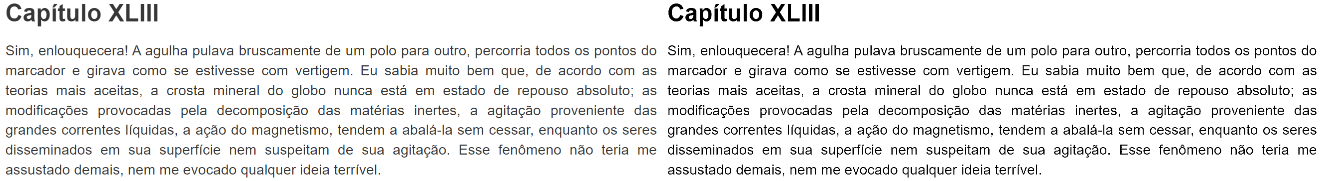

'Capítulo Sim, enlouquecera! A agulha pulava bruscamente de um polo para outro, percorria todos os pontos do marcador e girava como se estivesse com vertigem. Eu sabia muito bem que, de acordo com as teorias mais aceitas, a crosta mineral do globo nunca está em estado de repouso absoluto; as modificações provocadas pela decomposição das matérias inertes, a agitação proveniente das grandes correntes líquidas, a ação do magnetismo, tendem a abalá-la sem cessar, enquanto os seres disseminados em sua superfície nem suspeitam de sua agitação. Esse fenômeno não teria me assustado demais, nem me evocado qualquer ideia terrível.'

In [17]:
imagem, texto = extrair_texto(imagens['trecho_de_livro_digitalizado'])
cv2_imshow(imagem)
texto

### <strong><font color=006BA6>7.1.2 Trecho de livro (fotografado)</font></strong>

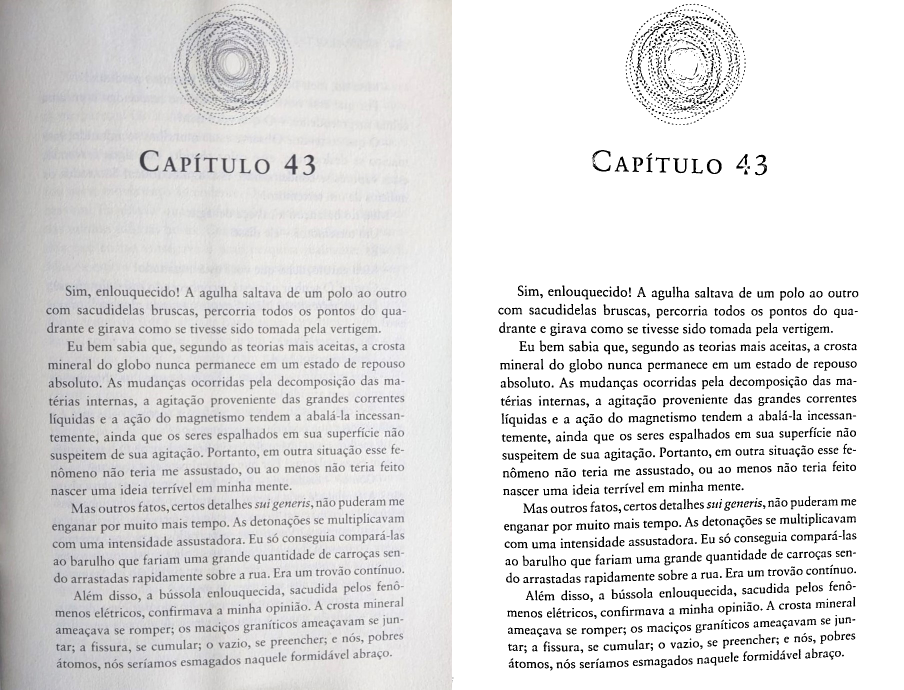

"  CAPÍTULO 43 Sim, enlouquecido! A agulha saltava de um polo ao outro com sacudidelas bruscas, percorria todos os pontos do qua- drante e girava como se tivesse sido tomada pela vertigem. Eu bem sabia que, segundo as teorias mais aceitas, a crosta mineral do globo nunca permanece em um estado de repouso absoluto. As mudanças ocorridas pela decomposição das ma- térias internas, a agitação proveniente das grandes correntes líquidas e a ação do magnetismo tendem a abalá-la incessan- temente, ainda que os seres espalhados em sua superfície não suspeitem de sua agitação. Portanto, em outra situação esse fe- nômeno não teria me assustado, ou menos não teria feito nascer uma ideia terrível em minha mente. Mas outros fatos, certos detalhes sui generis, não puderam me enganar por muito mais tempo. As detonações se com uma intensidade assustadora. Eu só conseguia compará-las ao barulho que fariam uma grande quantidade de sen- do arrastadas rapidamente sobre a rua. Era um trovão contínuo. Além d

In [23]:
imagem, texto = extrair_texto(imagens['trecho_livro_vertical'])
cv2_imshow(imagem)
texto

### <strong><font color=006BA6>7.1.3 Frase</font></strong>

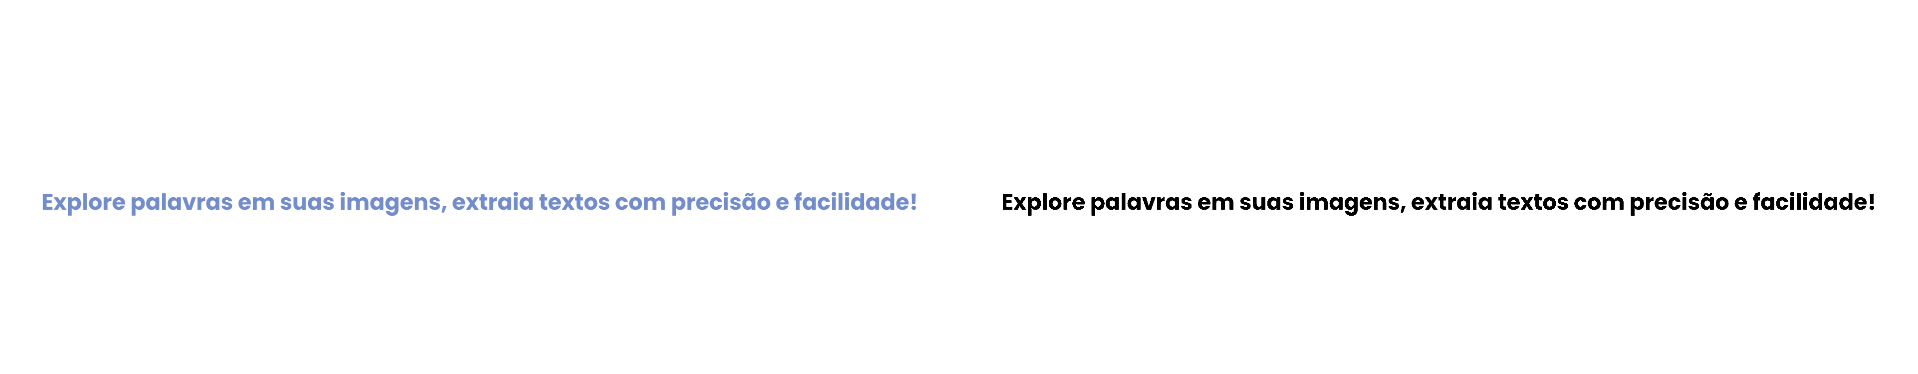

'Explore palavras em suas imagens, extraia textos com precisão e facilidade!'

In [18]:
imagem, texto = extrair_texto(imagens['frase'])
cv2_imshow(imagem)
texto

### <strong><font color=006BA6>7.1.4 Fatura</font></strong>

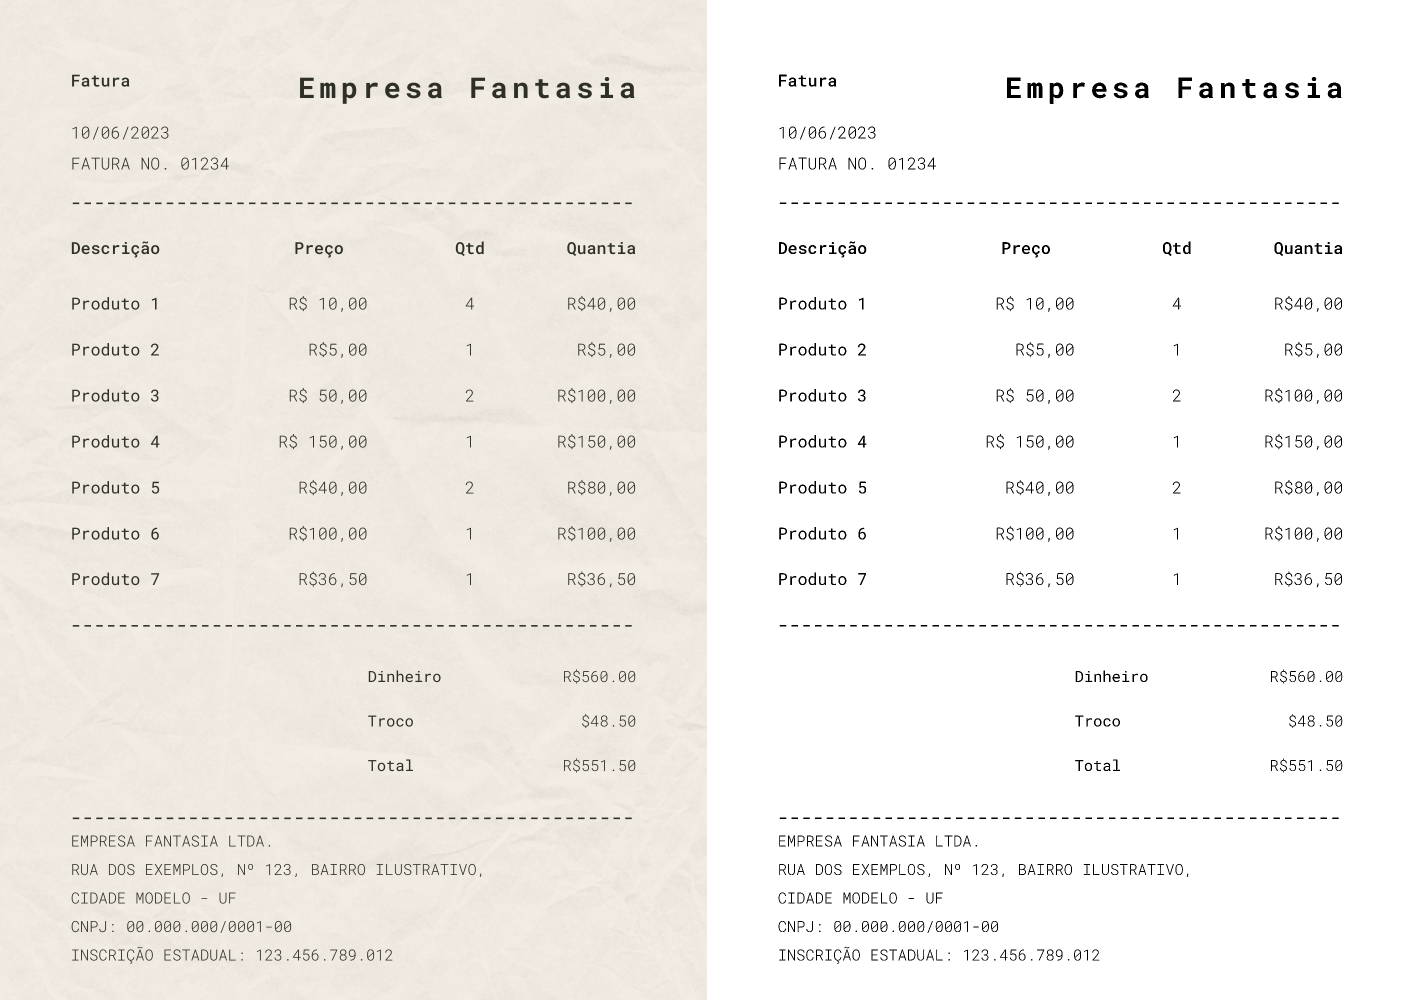

'Fatura Empresa Fantasia 10/06/2023 FATURA NO. 091234 Descrição Preço Qtd Quantia Produto 1 R$ 10,00 4 R$40, 0909 Produto 2 RS5, 00 1 Produto 3 R$ 50,00 2 R$100,00 Produto 4 R$ 150,00 1 Produto 5 R$40, 00 2 Produto 6 R$100,00 1 Produto 7 R$36, 50 1 R$36, 50 Dinheiro R$560 .00 Troco Total EMPRESA FANTASIA LTDA. RUA DOS EXEMPLOS, Nº 123, BAIRRO ILUSIRATIVO, CIDADE MODELO - UF CNPJ : INSCRIÇÃO ESTADUAL: 123.456.789.012'

In [24]:
imagem, texto = extrair_texto(imagens['fatura'])
cv2_imshow(imagem)
texto

## <strong><font color=006BA6>7.2 Orientação</font></strong>

O objetivo deste capítulo é analisar como a detecção de caracteres se comporta diante de imagens com diferentes orientações.

> **O que é esperado?** *Independente do ângulo de inclinação da imagem, o programa deverá ser capaz de rotacioná-la de modo que seu texto fique reto e esteja organizado de cima para baixo.*

### <strong><font color=006BA6>7.2.1 Imagem na horizontal (1)</font></strong>

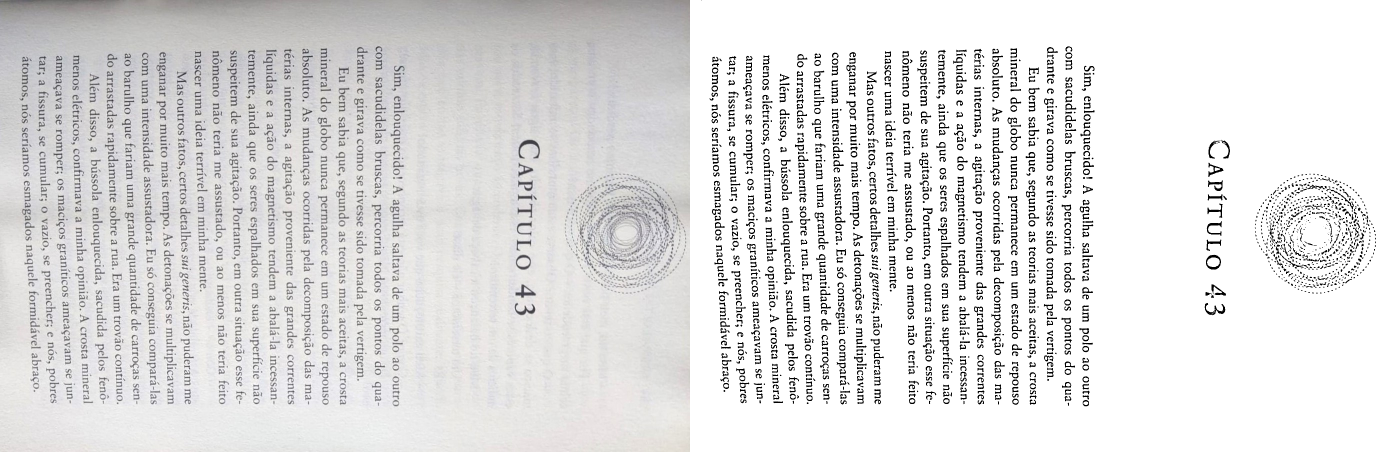

'  CAPÍTULO 43 Sim, enlouquecido! À agulha saltava de um polo ao outro com sacudidelas bruscas, percorria todos os pontos do qua- drante e girava como se tivesse sido tomada pela vertigem. Eu bem sabia que, segundo as teorias mais aceitas, a crosta mineral do globo nunca permanece em um estado de repouso absoluto. As mudanças ocorridas pela decomposição das ma- térias internas, agitação proveniente das grandes correntes líquidas e a ação do magnetismo tendem a abalá-la incessan- temente, ainda que os seres espalhados em sua superfície não suspeitem de sua agitação. Portanto, em outra situação esse fe- nômeno não teria me assustado, ou menos não teria feito nascer uma ideia terrível em minha mente. Mas outros fatos, certos detalhes sui generis, não puderam me enganar por muito mais tempo. Às detonações se multiplicavam com uma intensidade assustadora. Eu só conseguia compará-las ao barulho que fariam uma grande quantidade de carroças sen- do arrastadas rapidamente sobre a rua. Era um tr

In [26]:
imagem, texto = extrair_texto(imagens['trecho_livro_horizontal_1'])
cv2_imshow(imagem)
texto

### <strong><font color=006BA6>7.2.2 Imagem na horizontal (2)</font></strong>

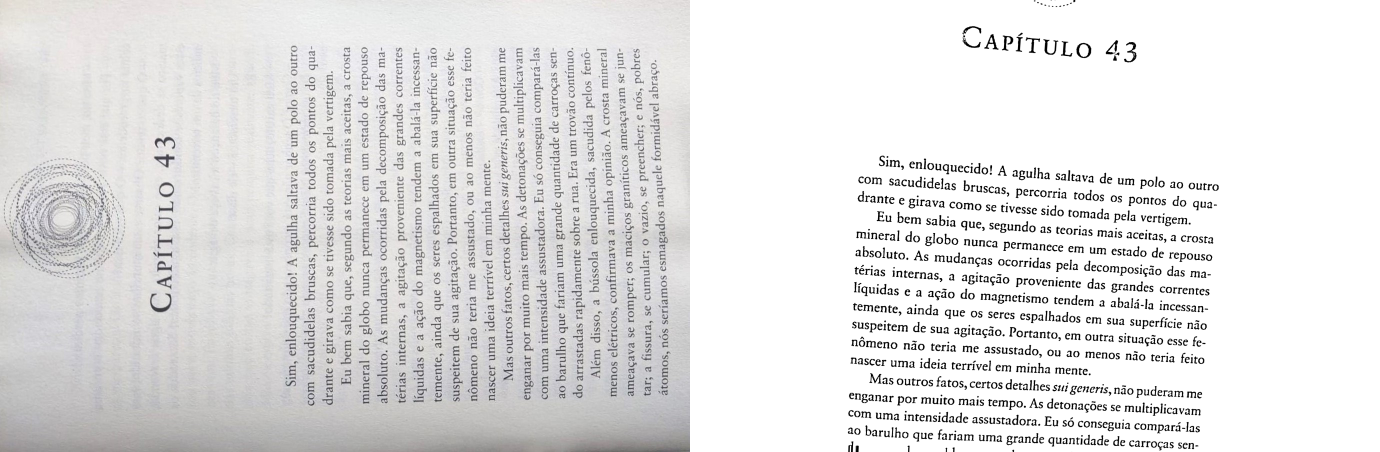

'nômeno não teria me assustado, ou ao menos não teria feito nascer uma ideia terrível em minha mente. Mas outros fatos, certos detalhes Sui generis, não puderam me por muito mais tempo. As detonações se multiplicavam com uma intensidade assustadora. Eu só conseguia compará-las ao barulho que fariam uma grande quantidade de Carroças sen- da q 11 q'

In [27]:
imagem, texto = extrair_texto(imagens['trecho_livro_horizontal_2'])
cv2_imshow(imagem)
texto

### <strong><font color=006BA6>7.2.3 Imagem levemente inclinada</font></strong>

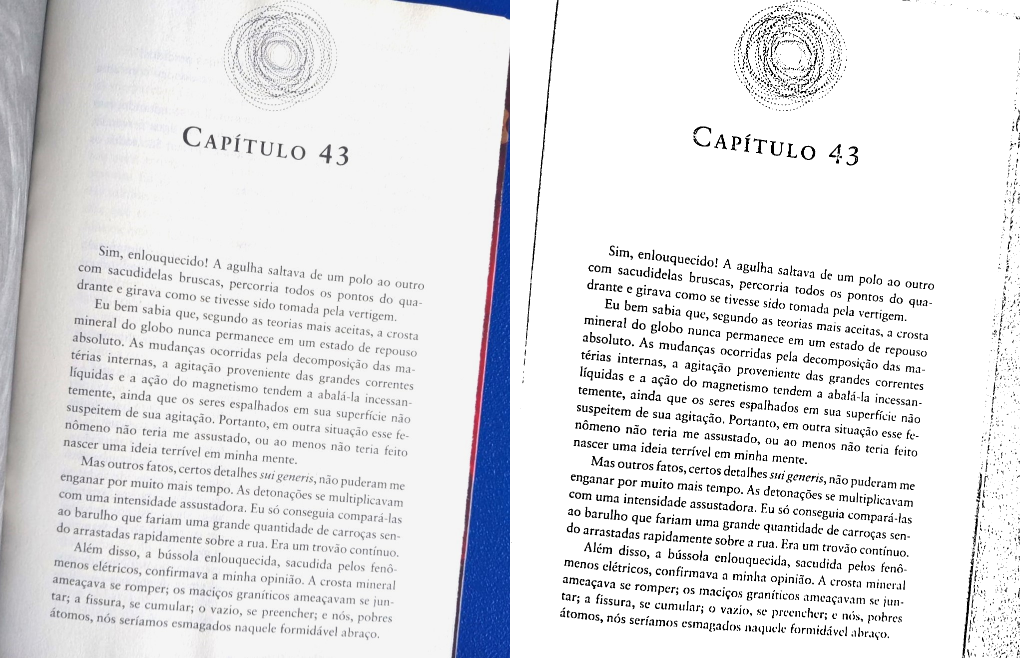

"  Sim, enlouquecído.' A agulha saltava de um Polo ao outro sacudidelas bruscas, Percorria todos os do qua- absoluto. mudanças ocorridas pela decomposição das ma- térias ínternas, 2 agitação Proveniente das correntes líquidas e a ação do magnetismo tendem abalá-la incessan- ainda que os seres espalhados em superfície não Suspeitem de sua Portanto, em OUtra situação esse fe- Mas outros fatos, certos detalhes su; não puderam me por muito Mais tempo, detonações se multiplicavam com uma intensidade assustadora. Eu só COnseguia compará-las ao barulho que fariam uma grande quantidade de sen- do arrastadas rapidamente sobre a rua. Era um trovão Contmu?. Além disso, a bússola enlouquecida, sacudida pelos elétricos, confirmava a minha opinião, À crosta se romper; os graníticos se jun- tar; a físsura, se cumular; o vazio, se nos, pobres :ítomos, nós seríamos esmagados naquele formidável abraço. "

In [33]:
imagem, texto = extrair_texto(imagens['trecho_livro_inclinado'])
cv2_imshow(imagem)
texto

### <strong><font color=006BA6>7.2.4 Imagem invertida</font></strong>

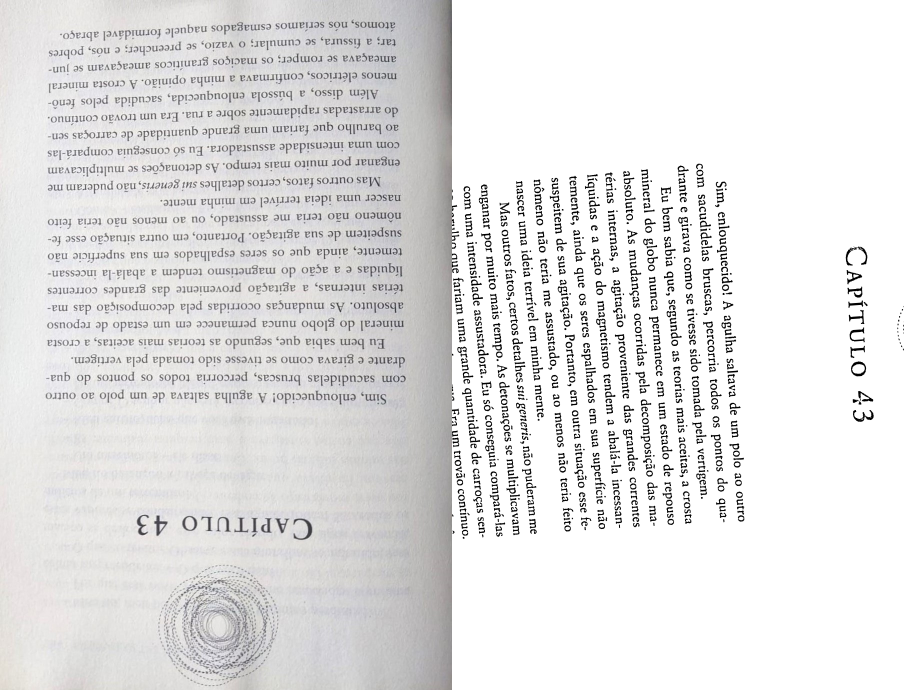

'Sim, enlouquecido! À agulha saltava de um polo ao outro com sacudidelas bruscas, percorria todos os pontos do qua- drante e girava como tivesse sido tomada pela vertigem. Eu bem sabia que, segundo as teorias mais aceitas, a crosta mineral do globo nunca permanece em um estado de repouso absoluto. mudanças ocorridas pela decomposição das ma- térias internaS, à agitação proveniente das grandes correntes líquidas e a ação do magnetismo tendem abalá-la incessan- temente, ainda que os seres espalhados em sua superfície não suspeitem de sua Portanto, em situação esse fe- nômeno não teria Me assustado, 40 menos não teria feito nascer uma ideia terrível em minha mente- Mas outros certos detalhes sui generis, não puderam me enganar pof muito mais As detonações com uma intensidade assustadora. Eu só conseguia compará-las que fariam UMA grande Q:uaauam de carroças Sen- . um trovão contínvo.'

In [29]:
imagem, texto = extrair_texto(imagens['trecho_livro_vertical_invertido'])
cv2_imshow(imagem)
texto

## <strong><font color=006BA6>7.3 Imagens escuras e com sombra</font></strong>

O objetivo deste capítulo é observar como o tratamento de imagens ocorre quando estas são escuras ou são claras e possuem sombras/pontos escurecidos.

> **O que é esperado?** *Em imagens realmente escuras (fundo escuro e texto claro), espera-se que ocorra uma inverção de tons, de modo que o fundo fique claro e o texto, escuro. Com relação à segunda categoria analisada, espera-se que as sombras sejam removidas da imagem.*

### <strong><font color=006BA6>7.3.1 Fotografia de trecho de livro com sombra</font></strong>

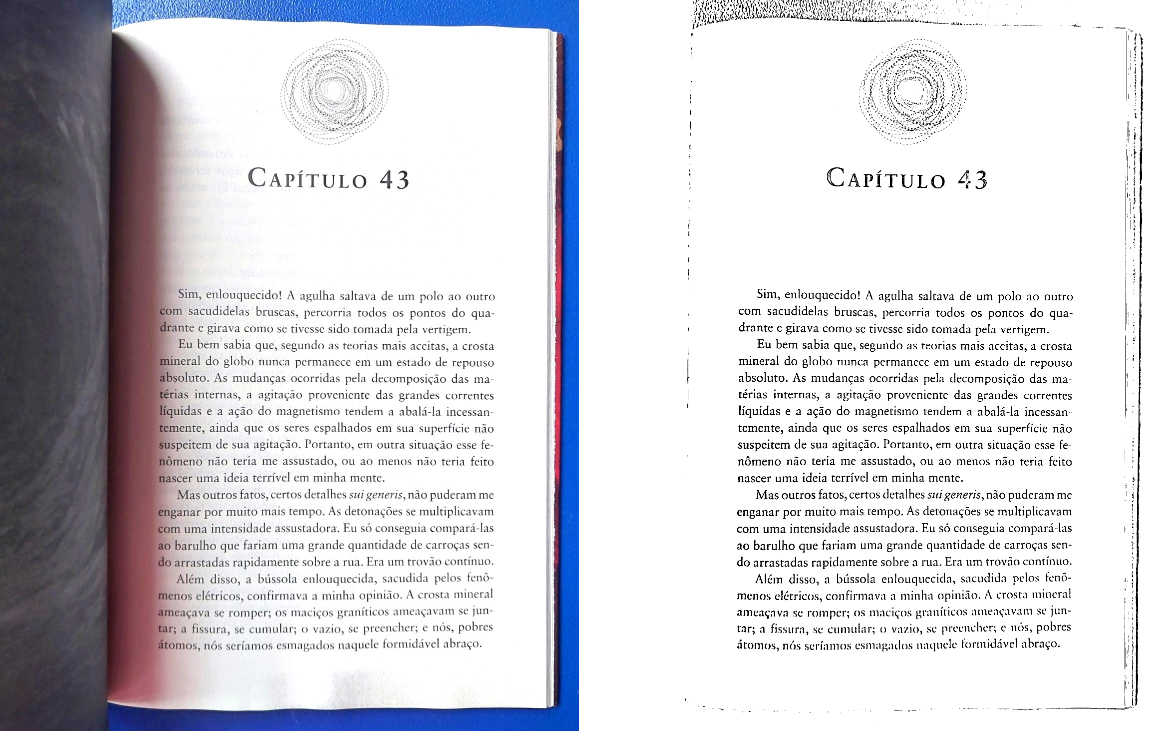

'nÁ _1   CaPÍTULO 43 Sim, enlouquecido! À agulha saltava de um polo ao outro com sacudidelas bruscas, percorria todos os pontos do qua- drante e girava como se tivesse sido tomada pela vertigem. Eu bem sabia que, segundo as teorias mais aceitas, a crosta mineral do globo nunca permanece em um estado de repouso absoluto. mudanças ocorridas pela decomposição das ma- térias internas, a agitação proveniente das grandes correntes líquidas e a ação do magnetismo tendem a abalá-la incessan- temente, ainda que os seres espalhados em sua superfície não suspeitem de sua agitação. Portanto, em outra situação esse fe- nômeno não teria me assustado, ou ao menos não teria feito nascer uma ideia terrível em minha mente. Mas outros fatos, certos detalhes sui não puderam me enganar por muito mais tempo. As detonações se multiplicavam com uma intensidade assustadora. Eu só conseguia compará-las ao barulho que fariam uma grande quantidade de carroças sen- do arrastadas rapidamente sobre a rua. Era um tro

In [32]:
imagem, texto = extrair_texto(imagens['trecho_livro_sombra'])
cv2_imshow(imagem)
texto

### <strong><font color=006BA6>7.3.2 Imagem escura</font></strong>

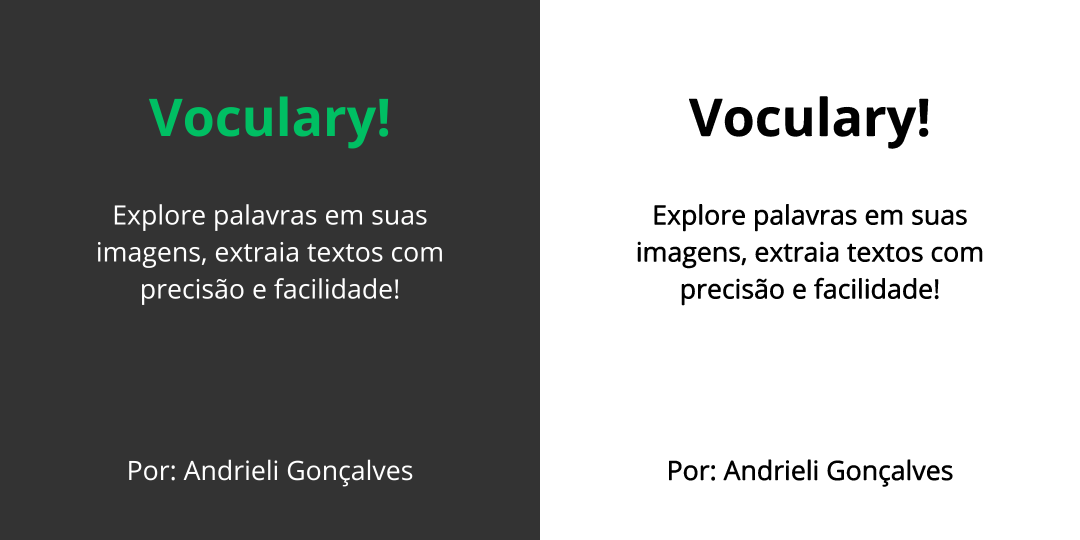

'Voculary! Explore palavras em suas imagens, extraia textos com precisão e facilidade! Por: Andrieli Gonçalves'

In [31]:
imagem, texto = extrair_texto(imagens['imagem_escura'])
cv2_imshow(imagem)
texto